https://colab.research.google.com/drive/1z1ORSrhKQhLsS0d4vPfYzcsjUpHh6HTR?usp=sharing

In [136]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

Загрузим уже обработанные данные из прошлых работ.

In [137]:
dataframe = pd.read_csv("abalone_preprocessed.csv",index_col=0)

In [138]:
dataframe.shape

(4177, 11)

In [139]:
dataframe.head()

,Female,Infant,Male,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.0,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1.0,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.0,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Для задачи классификации заменим значение количества колец на метки 0 - молодой, 1 - средний, 2 - старый.

In [140]:
for i in range(len(dataframe)):
  # young
  if(dataframe['Rings'][i] < 8):
    dataframe['Rings'][i] = 0
  # middle
  elif(dataframe['Rings'][i] < 12):
    dataframe['Rings'][i] = 1
  else:
  # old
    dataframe['Rings'][i] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [141]:
dataframe.head()

,Female,Infant,Male,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2
1,0.0,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
2,1.0,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1
3,0.0,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1
4,0.0,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0


Преобразуем значения полов к типу int.

In [142]:
dataframe['Female'] = dataframe['Female'].astype(int)
dataframe['Male'] = dataframe['Male'].astype(int)
dataframe['Infant'] = dataframe['Infant'].astype(int)

Разделим данные для обучения и проверки

In [143]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 3342 samples for training and 835 for validation


Преобразуем датафрем в датасет

In [144]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Rings")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Сгруппируем наборы данных

In [145]:
train_ds = train_ds.batch(10)
val_ds = val_ds.batch(10)

Определим функции:
encode_numerical_feature для поэлементной нормализации к числовым признакам;
encode_integer_categorical_feature для быстрого кодирования целочисленных категориальных функций.

In [146]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_integer_categorical_feature(feature, name, dataset):
    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    encoder.adapt(feature_ds)

    encoded_feature = encoder(feature)
    return encoded_feature

Начнём строить модель.

In [147]:
# Категориальные признаки закодированные как целые числа
female = keras.Input(shape=(1,), name="Female", dtype="int64")
infant = keras.Input(shape=(1,), name="Infant", dtype="int64")
male = keras.Input(shape=(1,), name="Male", dtype="int64") 

# Числовые признаки
length = keras.Input(shape=(1,), name="Length")
diameter = keras.Input(shape=(1,), name="Diameter")
whole_weight = keras.Input(shape=(1,), name="Whole weight")
shucked_weight = keras.Input(shape=(1,), name="Shucked weight")
viscera_weight = keras.Input(shape=(1,), name="Viscera weight")
shell_weight = keras.Input(shape=(1,), name="Shell weight")

In [148]:
all_inputs = [female,infant,male,length,diameter, whole_weight, shucked_weight, viscera_weight, shell_weight]

In [149]:
# Целочисленные признаки
female_encoded = encode_integer_categorical_feature(female, "Female", train_ds)
infant_encoded = encode_integer_categorical_feature(infant, "Infant", train_ds)
male_encoded = encode_integer_categorical_feature(male, "Male", train_ds)

# Числовые признаки
length_encoded = encode_numerical_feature(length, "Length", train_ds)
diameter_encoded = encode_numerical_feature(diameter, "Diameter", train_ds)
whole_weight_encoded = encode_numerical_feature(whole_weight, "Whole weight", train_ds)
shucked_weight_encoded = encode_numerical_feature(shucked_weight, "Shucked weight", train_ds)
viscera_weight_encoded = encode_numerical_feature(viscera_weight, "Viscera weight", train_ds)
shell_weight_encoded = encode_numerical_feature(shell_weight, "Shell weight", train_ds)

In [150]:
all_features = layers.concatenate([female_encoded,infant_encoded, male_encoded, length_encoded,
                                   diameter_encoded, whole_weight_encoded, shucked_weight_encoded,
                                   viscera_weight_encoded, shell_weight_encoded])

In [151]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

Компилируем модель keras

In [152]:
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Визуализируем модель

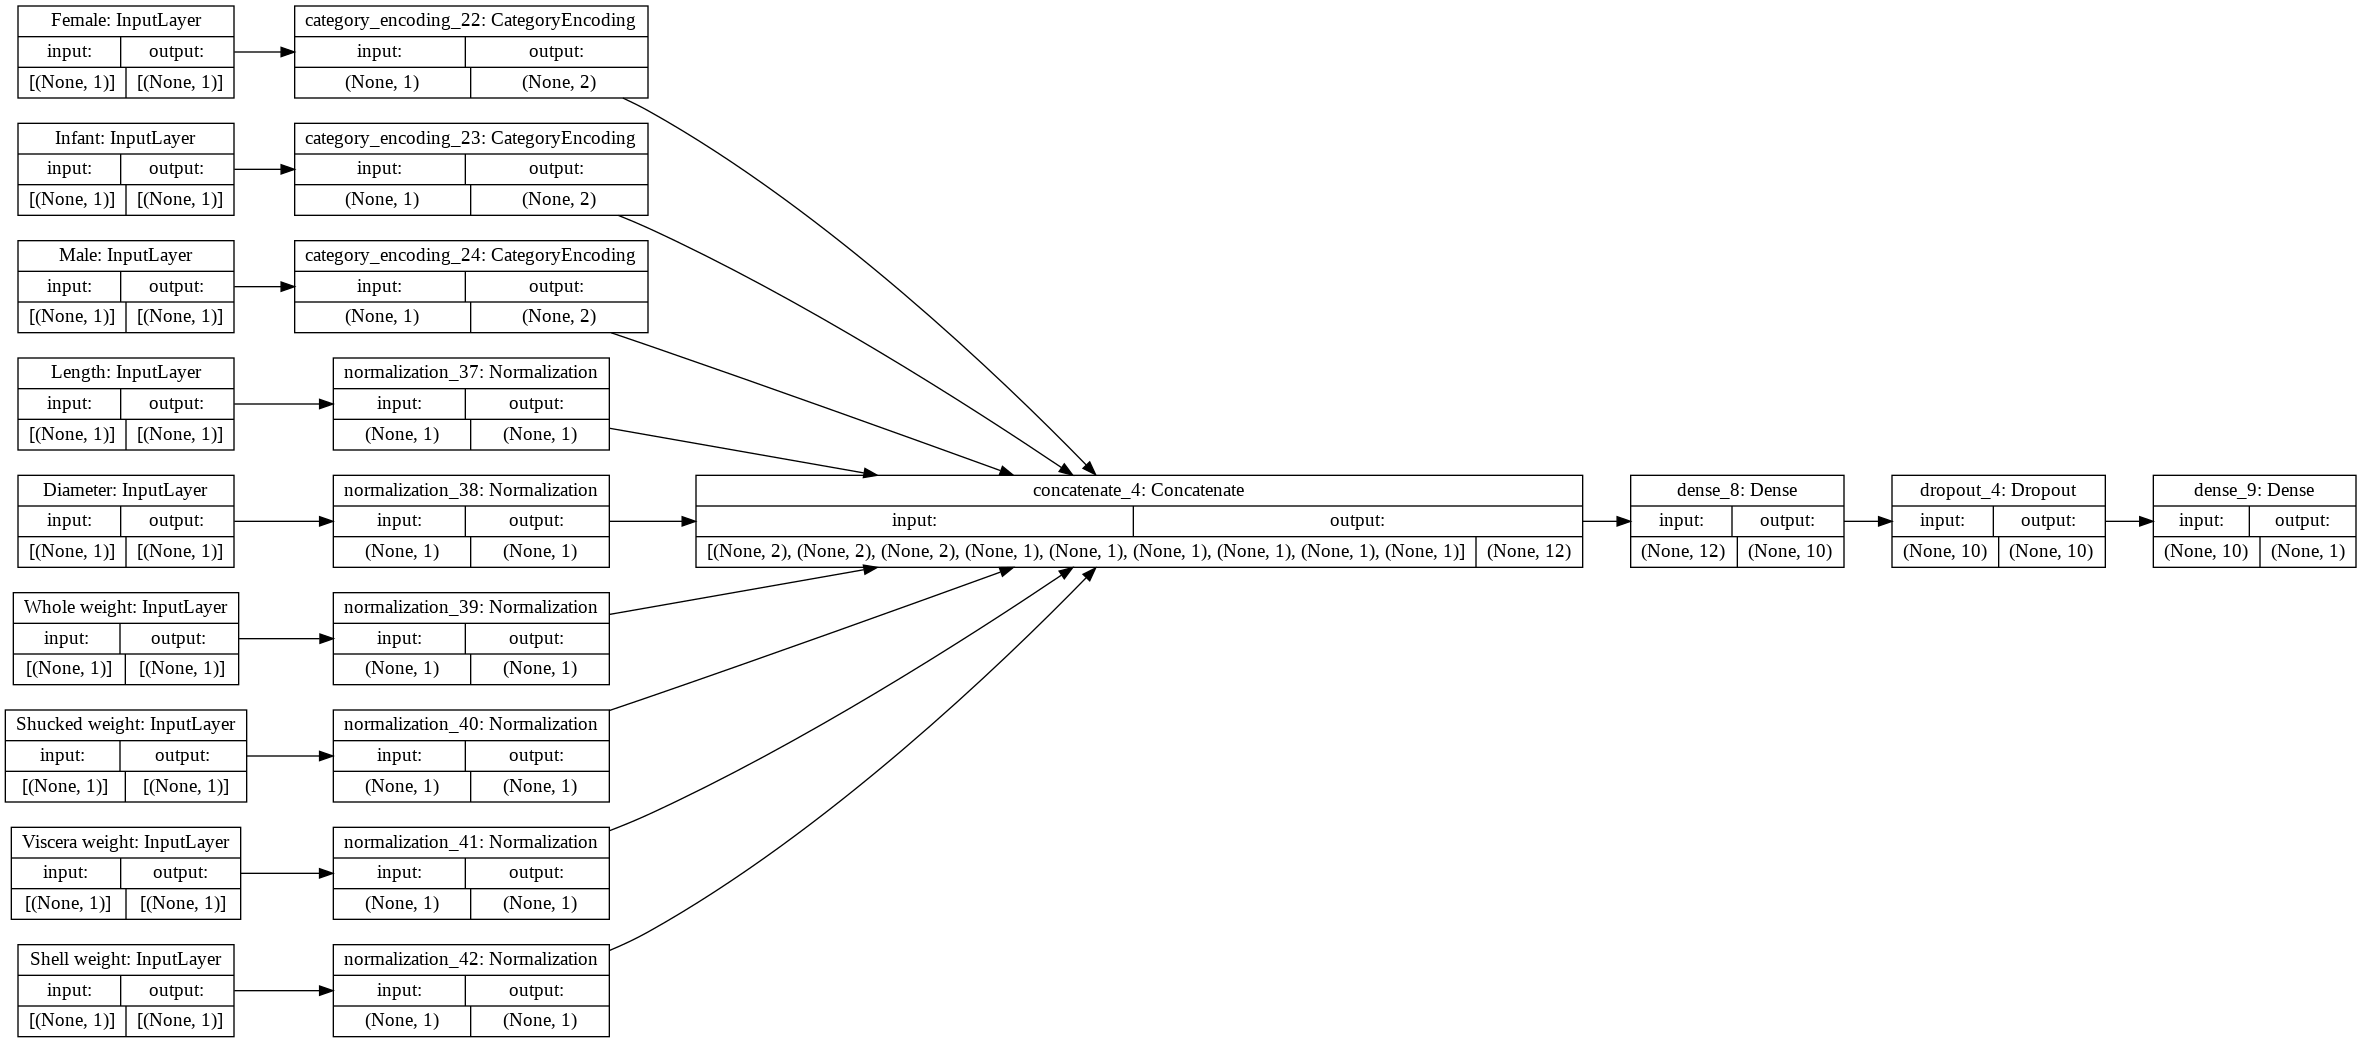

In [153]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [154]:
model.fit(train_ds, epochs=150,batch_size=10,validation_data=val_ds)

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['Height'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


335/335 [==============================] - 2s 3ms/step - loss: 0.5657 - accuracy: 0.4259 - val_loss: -0.5246 - val_accuracy: 0.6695
Epoch 2/150
335/335 [==============================] - 1s 2ms/step - loss: -1.0500 - accuracy: 0.6451 - val_loss: -2.2795 - val_accuracy: 0.6778
Epoch 3/150
335/335 [==============================] - 1s 2ms/step - loss: -3.3920 - accuracy: 0.6603 - val_loss: -5.0703 - val_accuracy: 0.6826
Epoch 4/150
335/335 [==============================] - 1s 2ms/step - loss: -7.2441 - accuracy: 0.6576 - val_loss: -8.9698 - val_accuracy: 0.6886
Epoch 5/150
335/335 [==============================] - 1s 2ms/step - loss: -11.7943 - accuracy: 0.6561 - val_loss: -14.3156 - val_accuracy: 0.6814
Epoch 6/150
335/335 [==============================] - 1s 2ms/step - loss: -18.7853 - accuracy: 0.6404 - val_loss: -21.0378 - val_accuracy: 0.6814
Epoch 7/150
335/335 [==============================] - 1s 2ms/step - loss: -26.7335 - accuracy: 0.6545 - val_loss: -28.4363 - val_accuracy:

In [162]:
model.save("my_model")

ValueError: ignored